### r: Erosion and Vegetation cover

In [1]:
# import libraries

import pandas as pd
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import numpy as np
import math
import os
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap, Normalize

In [2]:
# settings
work_directory = r'C:\Users\...\Code'

os.chdir(work_directory)

# setting: font
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}
mpl.rc('font', **font)  # pass in the font dict as kwargs

In [3]:
# loading data # Check the "DataProcessFlow.xlsx" for detailed information on this data.

data_directory = 'Data/crn_basins_1.csv'
data0 = pd.read_table(data_directory, sep=',', header=0, index_col='OBSID1')

# discard samples with significant errors (bigger than Denudation)
data0['EBE_ERR-EBE_MMKYR'] = data0['EBE_ERR']-data0['EBE_MMKYR']
data0 = data0[data0['EBE_ERR-EBE_MMKYR']<0]
data0 = data0.drop(labels='EBE_ERR-EBE_MMKYR', axis='columns')

# restrict mean annual precipitation to less than its 90% percentile, which is 2242 mm
data0 = data0[data0['MAPrecip'] <= 2242]

# restrict sample materials to "sand" only
data0 = data0[data0['MATERIAL'].isin(['Sa', 'Sed'])]

# the timescale of 1-1,000 kyr corresponding to Denudation rates of 1-1000 mm/kyr
data0 = data0[1<=data0['EBE_MMKYR']]
data0 = data0[data0['EBE_MMKYR'] <= 1000]

# restrict catchments to NDVI>=0
data0 = data0[0 <= data0['NDVI']]

# convert Denudation rate to logarithmic form
data0['log_EBE_MMKYR'] = data0['EBE_MMKYR'].apply(math.log)

# convert slope's unit to degrees: math.degrees(math.atan(slope gradient/1000))
data0['SLP_deg'] = (data0['SLP_AVE'] / 1000).apply(math.atan).apply(math.degrees)


# data overview (1955 Be-10 samples are qualified)
# data0
math.ceil(data0['SLP_deg'].max())
# data0.columns

40

In [4]:
# functions

def get_correlation_coefficient(data,
                                slope_windowsize=10,
                                precipitation_range=[],
                                erosion_field='log_EBE_MMKYR',
                                slop_field='SLP_deg',
                                precipitation_field='MAPrecip',
                                NDVI_field='NDVI'):
    ## define some parameters
    r_corr = []
    Slope_window = []
    Precip_window = []
    Number_samples = []
    P_value = []
    NDVI_distribution = []
    i = 0

    slop_max = math.ceil(data[slop_field].max())

    while i < (slop_max-slope_windowsize+1):
        
        ## control variables
        data_copy = data
        # slope window, moving step=10
        data_copy = data_copy[i <= data_copy[slop_field]]
        data_copy = data_copy[data_copy[slop_field] <= i+slope_windowsize]
        # precipitation
        data_copy = data_copy[precipitation_range[0] <= data_copy[precipitation_field]]
        data_copy = data_copy[data_copy[precipitation_field] <= precipitation_range[1]]
        
        ## calculation
        # pearson r: precipitation and Denudation; and p-value
        r, p = stats.pearsonr(data_copy[erosion_field], data_copy[NDVI_field])
        r_corr.append(round(r, ndigits=4))
        P_value.append(p)
        
        ## recording r's corresponding 'slope window'
        Slope_tuple = [i, i+slope_windowsize]
        Slope_window.append(Slope_tuple)

        ## recording r's corresponding 'precipitation window'
        Precip_window.append(precipitation_range)
        
        ## recording the volume of samples on each slope window
        Number_samples.append(data_copy.shape[0])

        ## recording NDVI distribution on each slope window
        NDVI_distribution.append(data_copy[NDVI_field])
        
        ## moving slope window with moving step=10 degrees
        i = i+1
        
    ## generate a new data_copy frame
    df_r = pd.DataFrame({
        "r" : r_corr,
        "P" : P_value,
        "Number" : Number_samples,
        "Slope": Slope_window,
        "Precip" : Precip_window
    })

    # output the data within the NDVI window
    data_selected = data
    data_selected = data_selected[precipitation_range[0] <= data_selected[precipitation_field]]
    data_selected = data_selected[data_selected[precipitation_field] <= precipitation_range[1]]
    
    return df_r, data_selected, NDVI_distribution

# define plotting function
def stem_plot_p_value(df_r,number=10):
    ## plotting, only for r with P-value < 0.05
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,2), dpi=100, constrained_layout=True)
    fig.patch.set_facecolor('white')
    ax.stem('r', linefmt='-', data=df_r[df_r['P'] < 0.05])
    ax.set_xticks([i for i in range(0, number)], labels=df_r[df_r['P'] < 0.05]['Slope'], rotation=90)
    ax.grid(True, linestyle='-.', axis='x', linewidth=0.5)
    return

def stem_plot(precipitation_range,df_r,data,sticks,transition_zone=10):
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 3), facecolor='white', dpi=100)
    # All r
    stem_all = ax.stem([i for i in range(0, 31)],'r', linefmt=(':'),  markerfmt=('o', 'grey'), data=df_r)
    # r with P-vale<0.05
    p_sticks = sticks
    stem_p_value = ax.stem(p_sticks, 'r', linefmt=('-'), label='r', markerfmt=('o'), data=df_r[df_r['P'] < 0.05])
    # add a vertical span
    ax.vlines(x=transition_zone, ymin=-1, ymax=1, color='grey', linestyles='dotted')
    ax.set_ylim(bottom=-0.5, top=0.5)
    ax.set_yticks([-0.4,-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4])
    ax.set_xticks([i for i in range(0, 31)], labels=df_r['Slope'], rotation=90)
    ax.legend((stem_p_value, stem_all), ('P-value<0.05', 'P-value>0.05'), loc='upper right', shadow=True)
    ax.grid(True, linestyle=':', axis='x', linewidth=0.5)
    ax.annotate('{}<=Precipitation<={};   N={};    Mean NDVI={};   Mean Precip = {}mm'.format(precipitation_range[0],precipitation_range[1],data.shape[0],
                                                                                                round(data[['NDVI']].apply(np.mean).iloc[0], 2),
                                                                                                int(data[['MAPrecip']].apply(np.mean).iloc[0])), (0,0.4))

    return

### Slope window = 10 degrees,  0<=MAPrecip<=800

In [5]:
df_r1, data1, NDVI_dis1 = get_correlation_coefficient(data0,
                                slope_windowsize=10,
                                precipitation_range=[0,800],
                                erosion_field='log_EBE_MMKYR',
                                slop_field='SLP_deg',
                                precipitation_field='MAPrecip',
                                NDVI_field='NDVI')
# df_r1
# data1

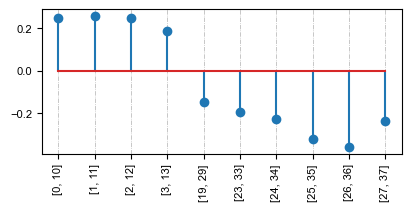

In [6]:
stem_plot_p_value(df_r=df_r1, number=10)

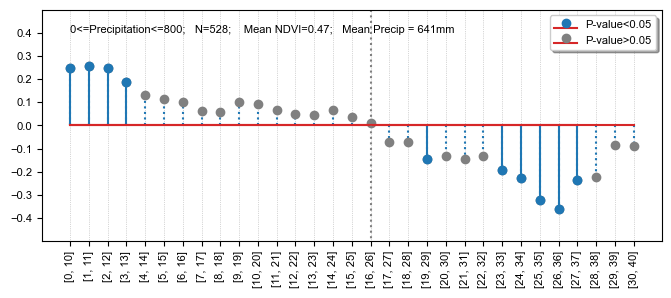

In [7]:
p_sticks = [i for i in range(0, 4)] + [19] + [i for i in range(23, 28)]
stem_plot(precipitation_range=[0,800],df_r=df_r1,data=data1,sticks=p_sticks,transition_zone=16)

### Slope window = 10 degree, 200<=MAPrecip<=1000

In [8]:
df_r2, data2, NDVI_dis2 = get_correlation_coefficient(data0,
                                slope_windowsize=10,
                                precipitation_range=[200,1000],
                                erosion_field='log_EBE_MMKYR',
                                slop_field='SLP_deg',
                                precipitation_field='MAPrecip',
                                NDVI_field='NDVI')

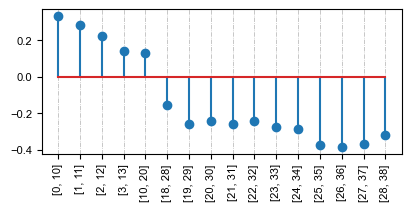

In [9]:
stem_plot_p_value(df_r=df_r2,number=16)

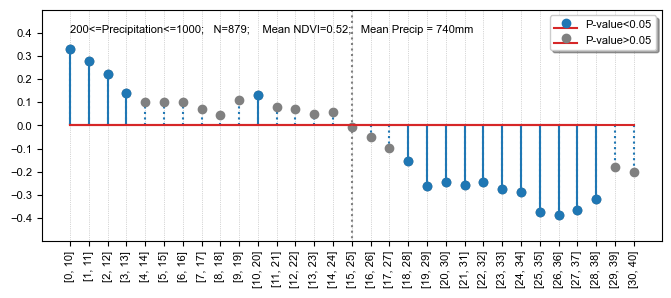

In [10]:
p_sticks = [i for i in range(0, 4)] + [10] + [i for i in range(18, 29)]
stem_plot(precipitation_range=[200,1000],df_r=df_r2,data=data2,sticks=p_sticks,transition_zone=15)

### Slope window = 10 degree, 400<=MAPrecip<=1200

In [11]:
df_r3, data3, NDVI_dis3 = get_correlation_coefficient(data0,
                                slope_windowsize=10,
                                precipitation_range=[400,1200],
                                erosion_field='log_EBE_MMKYR',
                                slop_field='SLP_deg',
                                precipitation_field='MAPrecip',
                                NDVI_field='NDVI')

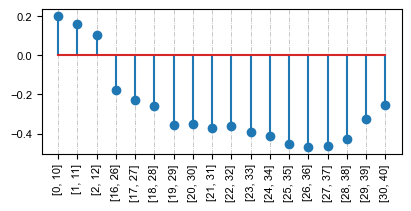

In [12]:
stem_plot_p_value(df_r=df_r3,number=18)

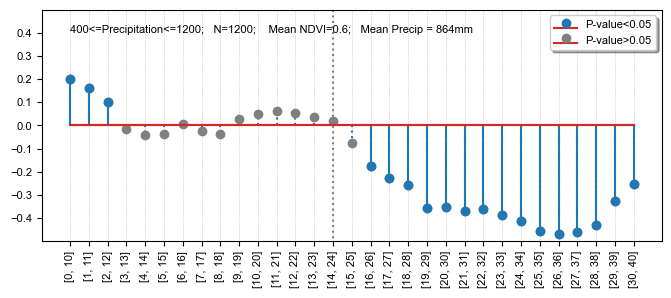

In [13]:
p_sticks = [i for i in range(0, 3)] + [i for i in range(16, 31)]
stem_plot(precipitation_range=[400,1200],df_r=df_r3,data=data3,sticks=p_sticks,transition_zone=14)

### Slope window = 10 degree, 600<=MAPrecip<=1400

In [14]:
df_r4, data4, NDVI_dis4 = get_correlation_coefficient(data0,
                                slope_windowsize=10,
                                precipitation_range=[600,1400],
                                erosion_field='log_EBE_MMKYR',
                                slop_field='SLP_deg',
                                precipitation_field='MAPrecip',
                                NDVI_field='NDVI')

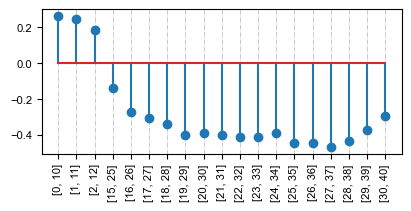

In [15]:
stem_plot_p_value(df_r=df_r4,number=19)

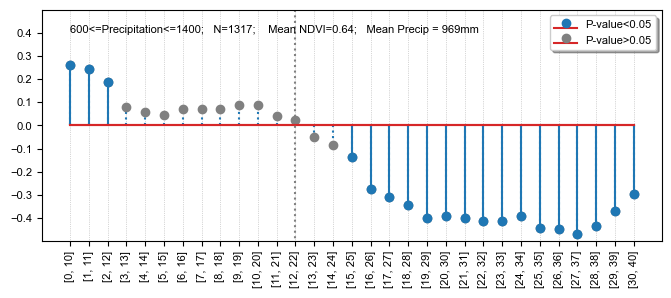

In [16]:
p_sticks = [i for i in range(0, 3)] +  [i for i in range(15, 31)]
stem_plot(precipitation_range=[600,1400],df_r=df_r4,data=data4,sticks=p_sticks,transition_zone=12)

### Slope window = 10 degree, 800<=MAPrecip<=1600

In [17]:
df_r5, data5, NDVI_dis5 = get_correlation_coefficient(data0,
                                slope_windowsize=10,
                                precipitation_range=[800,1600],
                                erosion_field='log_EBE_MMKYR',
                                slop_field='SLP_deg',
                                precipitation_field='MAPrecip',
                                NDVI_field='NDVI')

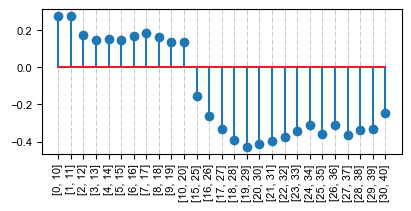

In [18]:
stem_plot_p_value(df_r=df_r5,number=27)

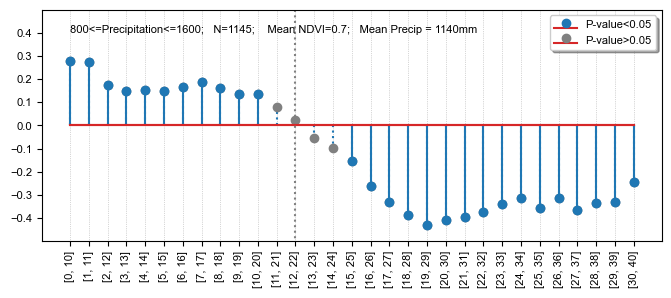

In [19]:
p_sticks = [i for i in range(0, 11)] + [i for i in range(15, 31)]
stem_plot(precipitation_range=[800,1600],df_r=df_r5,data=data5,sticks=p_sticks,transition_zone=12)

### Slope window = 10 degree, 1000<=MAPrecip<=1800

In [20]:
df_r6, data6, NDVI_dis6 = get_correlation_coefficient(data0,
                                slope_windowsize=10,
                                precipitation_range=[1000,1800],
                                erosion_field='log_EBE_MMKYR',
                                slop_field='SLP_deg',
                                precipitation_field='MAPrecip',
                                NDVI_field='NDVI')

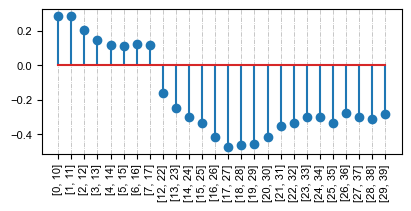

In [21]:
stem_plot_p_value(df_r=df_r6,number=26)

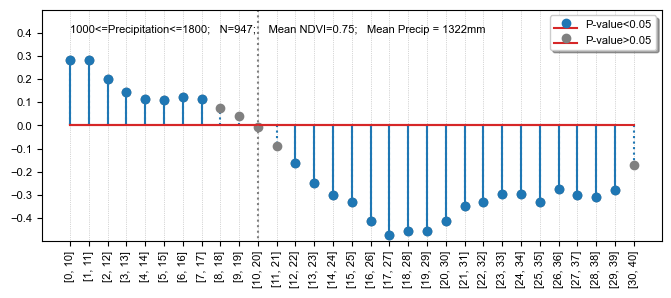

In [22]:
p_sticks = [i for i in range(0, 8)] + [i for i in range(12, 30)]
stem_plot(precipitation_range=[1000,1800],df_r=df_r6,data=data6,sticks=p_sticks,transition_zone=10)

### Slope window = 10 degree, 1200<=MAPrecip<=2000

In [23]:
df_r7, data7, NDVI_dis7 = get_correlation_coefficient(data0,
                                slope_windowsize=10,
                                precipitation_range=[1200,2000],
                                erosion_field='log_EBE_MMKYR',
                                slop_field='SLP_deg',
                                precipitation_field='MAPrecip',
                                NDVI_field='NDVI')

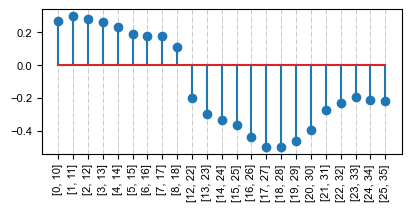

In [24]:
stem_plot_p_value(df_r=df_r7,number=23)

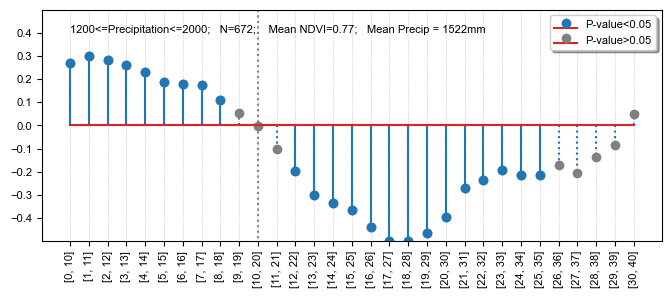

In [25]:
p_sticks = [i for i in range(0, 9)] + [i for i in range(12, 26)]
stem_plot(precipitation_range=[1200,2000],df_r=df_r7,data=data7,sticks=p_sticks,transition_zone=10)

### Slope window = 10 degree, 1400<=MAPrecip<=2300

In [26]:
df_r8, data8, NDVI_dis8 = get_correlation_coefficient(data0,
                                slope_windowsize=10,
                                precipitation_range=[1400,2300],
                                erosion_field='log_EBE_MMKYR',
                                slop_field='SLP_deg',
                                precipitation_field='MAPrecip',
                                NDVI_field='NDVI')

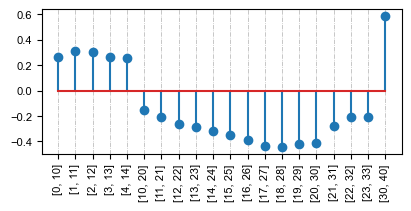

In [27]:
stem_plot_p_value(df_r=df_r8,number=20)

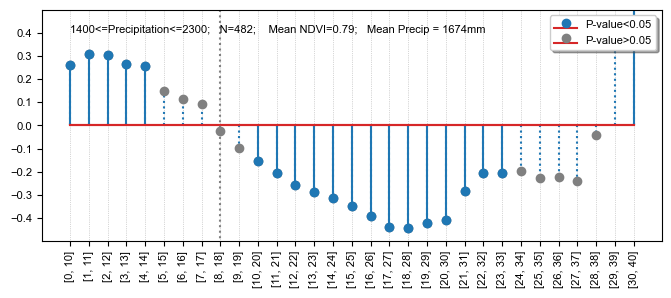

In [28]:
p_sticks = [i for i in range(0, 5)] + [i for i in range(10, 24)] + [30]
stem_plot(precipitation_range=[1400,2300],df_r=df_r8,data=data8,sticks=p_sticks,transition_zone=8)

#### Figure 2

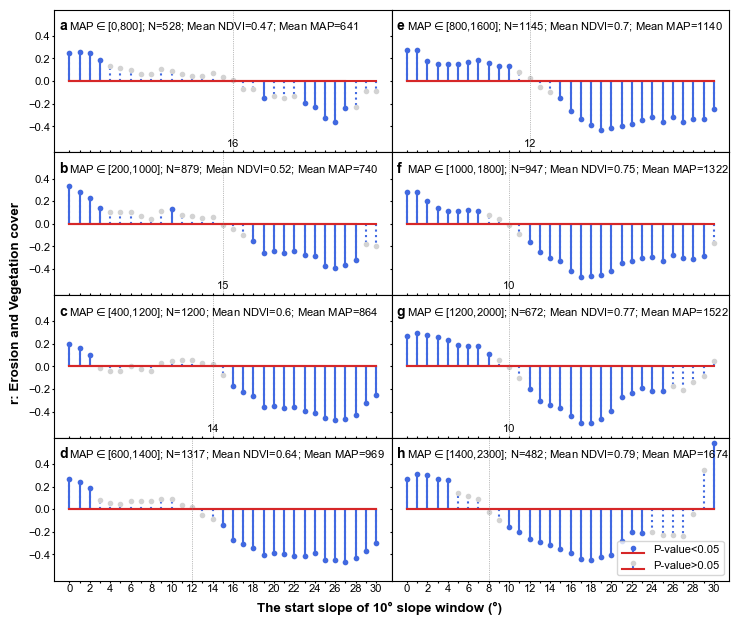

In [31]:
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=False, sharey=True, figsize=(7.7, 6.5), facecolor='white', dpi=100)
fig.tight_layout(pad=2.5)
fig.subplots_adjust(wspace=0, hspace=0)
# fig.suptitle('NDVI window=0.5; Slope windows=10°')
fig.supxlabel('The start slope of 10° slope window (°)', fontweight='bold', y=0.02)
fig.supylabel('r: Erosion and Vegetation cover', fontweight='bold')
# setting: font
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}
mpl.rc('font', **font)  # pass in the font dict as kwargs

ax00 = axs[0,0]
ax10 = axs[1,0]
ax20 = axs[2,0]
ax30 = axs[3,0]
ax01 = axs[0,1]
ax11 = axs[1,1]
ax21 = axs[2,1]
ax31 = axs[3,1]

p_sticks = [i for i in range(0, 4)] + [19] + [i for i in range(23, 28)]
ax00.stem([i for i in range(0, 31)],'r', linefmt=(':', 'royalblue'),  markerfmt=('.', 'lightgrey'), data=df_r1)
ax00.stem(p_sticks, 'r', linefmt=('-', 'royalblue'), label='red', markerfmt=('.', 'royalblue'), data=df_r1[df_r1['P'] < 0.05])
ax00.vlines(x=16, ymin=-1, ymax=1, color='grey', linestyles='dotted', linewidth=0.5)
ax00.set_ylim(bottom=-0.63, top=0.63)
ax00.set_yticks([-0.4,-0.2,0.0,0.2,0.4])
ax00.set_xticks([i for i in range(0, 31)], labels=['','','','','','','','','','','','','','','','',16,'','','','','','','','','','','','','',''])
ax00.tick_params(axis='y', length=1.5, pad=1)
ax00.tick_params(axis='x', direction='in', length=1.5, pad=-10)
ax00.annotate('MAP'+ r'$\in$' + '[0,800]; N={}; Mean NDVI={}; Mean MAP={}'.format(data1.shape[0], round(data1[['NDVI']].apply(np.mean).iloc[0], 2),int(data1[['MAPrecip']].apply(np.mean).iloc[0])), (0,0.45), fontsize=8)
ax00.annotate('a', (-1,0.45), fontweight='bold', fontsize=10)

p_sticks = [i for i in range(0, 4)] + [10] + [i for i in range(18, 29)]
ax10.stem([i for i in range(0, 31)],'r', linefmt=(':', 'royalblue'),  markerfmt=('.', 'lightgrey'), data=df_r2)
ax10.stem(p_sticks, 'r', linefmt=('-', 'royalblue'), label='r', markerfmt=('.', 'royalblue'), data=df_r2[df_r2['P'] < 0.05])
ax10.vlines(x=15, ymin=-1, ymax=1, color='grey', linestyles='dotted', linewidth=0.5)
ax10.set_xticks([i for i in range(0, 31)], labels=['','','','','','','','','','','','','','','',15,'','','','','','','','','','','','','','',''])
ax10.tick_params(axis='y', length=1.5, pad=1)
ax10.tick_params(axis='x', direction='in', length=1.5, pad=-10)
ax10.annotate('MAP'+ r'$\in$' + '[200,1000]; N={}; Mean NDVI={}; Mean MAP={}'.format(data2.shape[0], round(data2[['NDVI']].apply(np.mean).iloc[0], 2),int(data2[['MAPrecip']].apply(np.mean).iloc[0])), (0,0.45), fontsize=8)
ax10.annotate('b', (-1,0.45), fontweight='bold', fontsize=10)

p_sticks = [i for i in range(0, 3)] + [i for i in range(16, 31)]
ax20.stem([i for i in range(0, 31)],'r', linefmt=(':', 'royalblue'),  markerfmt=('.', 'lightgrey'), data=df_r3)
ax20.stem(p_sticks, 'r', linefmt=('-', 'royalblue'), label='r', markerfmt=('.', 'royalblue'), data=df_r3[df_r3['P'] < 0.05])
ax20.vlines(x=14, ymin=-1, ymax=1, color='grey', linestyles='dotted', linewidth=0.5)
ax20.set_xticks([i for i in range(0, 31)], labels=['','','','','','','','','','','','','','',14,'','','','','','','','','','','','','','','',''])
ax20.tick_params(axis='y', length=1.5, pad=1)
ax20.tick_params(axis='x', direction='in', length=1.5, pad=-10)
ax20.annotate('MAP'+ r'$\in$' + '[400,1200]; N={}; Mean NDVI={}; Mean MAP={}'.format(data3.shape[0], round(data3[['NDVI']].apply(np.mean).iloc[0], 2),int(data3[['MAPrecip']].apply(np.mean).iloc[0])), (0,0.45), fontsize=8)
ax20.annotate('c', (-1,0.45), fontweight='bold', fontsize=10)

p_sticks = [i for i in range(0, 3)] +  [i for i in range(15, 31)]
ax30.stem([i for i in range(0, 31)],'r', linefmt=(':', 'royalblue'),  markerfmt=('.', 'lightgrey'), data=df_r4)
ax30.stem(p_sticks, 'r', linefmt=('-', 'royalblue'), label='r', markerfmt=('.', 'royalblue'), data=df_r4[df_r4['P'] < 0.05])
ax30.vlines(x=12, ymin=-1, ymax=1, color='grey', linestyles='dotted', linewidth=0.5)
ax30.set_xticks([i for i in range(0, 31)], labels=[0,'',2,'',4,'',6,'',8,'',10,'',12,'',14,'',16,'',18,'',20,'',22,'',24,'',26,'',28,'',30])
ax30.tick_params(length=1.5, pad=1)
ax30.tick_params(axis='x', direction='out', length=1.5, pad=1)
ax30.annotate('MAP'+ r'$\in$' + '[600,1400]; N={}; Mean NDVI={}; Mean MAP={}'.format(data4.shape[0], round(data4[['NDVI']].apply(np.mean).iloc[0], 2),int(data4[['MAPrecip']].apply(np.mean).iloc[0])), (0,0.45), fontsize=8)
ax30.annotate('d', (-1,0.45), fontweight='bold', fontsize=10)

p_sticks = [i for i in range(0, 11)] + [i for i in range(15, 31)]
ax01.stem([i for i in range(0, 31)],'r', linefmt=(':', 'royalblue'),  markerfmt=('.', 'lightgrey'), data=df_r5)
ax01.stem(p_sticks, 'r', linefmt=('-', 'royalblue'), label='r', markerfmt=('.', 'royalblue'), data=df_r5[df_r5['P'] < 0.05])
ax01.vlines(x=12, ymin=-1, ymax=1, color='grey', linestyles='dotted', linewidth=0.5)
ax01.set_xticks([i for i in range(0, 31)], labels=['','','','','','','','','','','','',12,'','','','','','','','','','','','','','','','','',''])
ax01.set_ylim(bottom=-0.63, top=0.63)
ax01.set_yticks([-0.4,-0.2,0.0,0.2,0.4])
ax01.tick_params(axis='y', length=1.5, pad=1)
ax01.tick_params(axis='x', direction='in', length=1.5, pad=-10)
ax01.annotate('MAP'+ r'$\in$' + '[800,1600]; N={}; Mean NDVI={}; Mean MAP={}'.format(data5.shape[0], round(data5[['NDVI']].apply(np.mean).iloc[0], 2),int(data5[['MAPrecip']].apply(np.mean).iloc[0])), (0,0.45), fontsize=8)
ax01.annotate('e', (-1,0.45), fontweight='bold', fontsize=10)

p_sticks = [i for i in range(0, 8)] + [i for i in range(12, 30)]
ax11.stem([i for i in range(0, 31)],'r', linefmt=(':', 'royalblue'),  markerfmt=('.', 'lightgrey'), data=df_r6)
ax11.stem(p_sticks, 'r', linefmt=('-', 'royalblue'), label='r', markerfmt=('.', 'royalblue'), data=df_r6[df_r6['P'] < 0.05])
ax11.vlines(x=10, ymin=-1, ymax=1, color='grey', linestyles='dotted', linewidth=0.5)
ax11.set_xticks([i for i in range(0, 31)], labels=['','','','','','','','','','',10,'','','','','','','','','','','','','','','','','','','',''])
ax11.tick_params(axis='y', length=1.5, pad=1)
ax11.tick_params(axis='x', direction='in', length=1.5, pad=-10)
ax11.annotate('MAP'+ r'$\in$' + '[1000,1800]; N={}; Mean NDVI={}; Mean MAP={}'.format(data6.shape[0], round(data6[['NDVI']].apply(np.mean).iloc[0], 2),int(data6[['MAPrecip']].apply(np.mean).iloc[0])), (0,0.45), fontsize=8)
ax11.annotate('f', (-1,0.45), fontweight='bold', fontsize=10)

p_sticks = [i for i in range(0, 9)] + [i for i in range(12, 26)]
ax21.stem([i for i in range(0, 31)],'r', linefmt=(':', 'royalblue'),  markerfmt=('.', 'lightgrey'), data=df_r7)
ax21.stem(p_sticks, 'r', linefmt=('-', 'royalblue'), label='r', markerfmt=('.', 'royalblue'), data=df_r7[df_r7['P'] < 0.05])
ax21.vlines(x=10, ymin=-1, ymax=1, color='grey', linestyles='dotted', linewidth=0.5)
ax21.set_xticks([i for i in range(0, 31)], labels=['','','','','','','','','','',10,'','','','','','','','','','','','','','','','','','','',''])
ax21.tick_params(axis='y', length=1.5, pad=1)
ax21.tick_params(axis='x', direction='in', length=1.5, pad=-10)
ax21.annotate('MAP'+ r'$\in$' + '[1200,2000]; N={}; Mean NDVI={}; Mean MAP={}'.format(data7.shape[0], round(data7[['NDVI']].apply(np.mean).iloc[0], 2),int(data7[['MAPrecip']].apply(np.mean).iloc[0])), (0,0.45), fontsize=8)
ax21.annotate('g', (-1,0.45), fontweight='bold', fontsize=10)

p_sticks = [i for i in range(0, 5)] + [i for i in range(10, 24)] + [30]
stem_all = ax31.stem([i for i in range(0, 31)],'r', linefmt=(':', 'royalblue'),  markerfmt=('.', 'lightgrey'), data=df_r8)
stem_p_value = ax31.stem(p_sticks, 'r', linefmt=('-', 'royalblue'), label='r', markerfmt=('.', 'royalblue'), data=df_r8[df_r8['P'] < 0.05])
ax31.vlines(x=8, ymin=-1, ymax=1, color='grey', linestyles='dotted', linewidth=0.5)
ax31.set_xticks([i for i in range(0, 31)], labels=[0,'',2,'',4,'',6,'',8,'',10,'',12,'',14,'',16,'',18,'',20,'',22,'',24,'',26,'',28,'',30])
ax31.tick_params(length=1.5, pad=1)
ax31.annotate('MAP'+ r'$\in$' + '[1400,2300]; N={}; Mean NDVI={}; Mean MAP={}'.format(data8.shape[0], round(data8[['NDVI']].apply(np.mean).iloc[0], 2),int(data8[['MAPrecip']].apply(np.mean).iloc[0])), (0,0.45), fontsize=8)
ax31.annotate('h', (-1,0.45), fontweight='bold', fontsize=10)
ax31.legend((stem_p_value, stem_all), ('P-value<0.05', 'P-value>0.05'), loc='lower right', shadow=False, fontsize=8)

# plt.savefig("Results/240131/Figure2.svg", dpi=300, bbox_inches='tight')